# Accessing data through  ORNL DAAC web services

*Author: Rupesh Shrestha*  
*Date: March 21, 2018*  
*Contact for ORNL DAAC: uso@daac.ornl.gov*

### Keywords: web service, SOAP, Python, OGC, RESTful API, MODIS, Daymet, SDAT

## Overview

ORNL DAAC offers various tools and web services which allow programmatic access of the data (https://daac.ornl.gov/tools/). In this tutorial, we will use different web services to access and combine datasets near Deep Creek Ridge in Central Idaho **(lat = 45.0949, lon = -114.1086)**. There was a significant tree mortality due to bark beetles during 2009-2011 period (see https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1512).

![Annual EVI from MODIS](resources/evi.png)

## Source Data
This tutorial uses following web services:
* [MODIS web service](https://modis.ornl.gov/data/modis_webservice.html), a [SOAP](https://en.wikipedia.org/wiki/SOAP)-based service, to access [MODIS Land Products](https://modis.ornl.gov/documentation.html).
* [Daymet single-pixel tool](https://daymet.ornl.gov/web_services.html), a [REST](https://en.wikipedia.org/wiki/Representational_state_transfer)-ful web service to download daily weather parameters at a single geographic point.
* [Spatial Data Access Tools - SDAT](https://webmap.ornl.gov/ogc), an [OGC](http://www.opengeospatial.org/)-based web service to visualize and download spatial data in various user-selected spatial/temporal extents and formats.

## Prerequisites

Python 2.7 or later. Python modules: numpy, pandas, matplotlib, urllib, zeep, owslib

## Tutorial

## 1. Download precipitation data with Daymet single-pixel tool

Let's import some python modules:

In [1]:
%matplotlib inline
# above generates plots in line within this page

import numpy as np # numpy module for array operations
import pandas as pd # pandas module for tabular data
import matplotlib.pyplot as plt # matplotlib module for plotting
import datetime as dt # datetime module for converting dates
from urllib.request import urlretrieve # urllib module for saving url data to local file
from zeep import Client # zeep module for accessing MODIS SOAP service
from owslib.wms import WebMapService # OWSlib module to access WMS services from SDAT
from owslib.wcs import WebCoverageService  # OWSlib module to access WCS services from SDAT
from IPython.display import Image # Displaying image

The daymet single-pixel tool needs the url to be formated like "https://<i></i>daymet.ornl.gov/data/send/saveData?lat=**lat**&lon=**lon**&measuredParams=**params**&year=**years**" where **lat** and **lon** are the latitude and longitude values in decimal degrees, **params** is a comma-separated list of parameters (tmax,tmin,dayl,prcp,srad,swe,vp) and **years** is a comma-separated list of years.

Here, we will download daily precipitation data ('prcp') from 2003-2012 at our location of interest.

In [2]:
lat = 45.0949 # Deep Creek Ridge in Central Idaho 
lon = -114.1086

yrs = "2003,2004,2005,2006,2007,2008,2009,2010,2011,2012"

# Daymet URL. It is important that the URL is structured correctly
daymeturl = "https://daymet.ornl.gov/data/send/saveData?lat={lat}&lon={lon}&measuredParams=prcp&year={year}"

# save the daymet data to a file
daymet_file = "../data/outdata/daymet.csv"
daymet = urlretrieve(daymeturl.format(lat=lat, lon=lon, year=yrs), daymet_file)

# read daymet_file, first 6 lines are headers
daymetdf = pd.read_csv(daymet_file, header=6)

# convert year and day of year into python datetime
daymetdf.index = pd.to_datetime(daymetdf.year.astype(str) + '-' + 
                                daymetdf.yday.astype(str), format="%Y-%j")
# print the first five rows
daymetdf[:5]

,year,yday,prcp (mm/day)
2003-01-01,2003,1,0.0
2003-01-02,2003,2,7.0
2003-01-03,2003,3,7.0
2003-01-04,2003,4,5.0
2003-01-05,2003,5,5.0


Let us now rename the columns into something shorter, create annual precipitation, and plot the results.

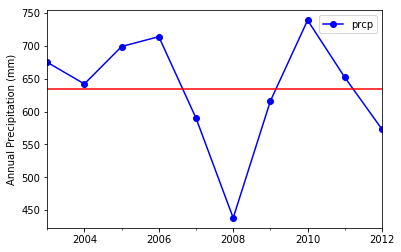

In [3]:
# rename column to 'prcp'
daymetdf=daymetdf.rename(columns = {'prcp (mm/day)':'prcp'})

# compute annual precipitation
daymetyr = daymetdf.groupby(pd.TimeGrouper('A')).aggregate(np.sum)

# plot
ax= daymetyr.prcp.plot(legend=True, marker='o', style='b')
plt.ylabel('Annual Precipitation (mm)')
plt.axhline(y=daymetyr.prcp.mean(), color='r', linestyle='-') # 10 year mean prcp

In the chart above, we can see that 2008 received less precipitation than rest of the other years. During a drought period, the water-stressed trees are more susceptible to the bark beetles.

## 2. Download vegetation index with MODIS webservice

Now, we will use ORNL DAAC's MODIS webservice to download the MODIS Vegetation Index (EVI from [MOD13Q1](https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mod13q1)). The MODIS product MOD13Q1 is a gridded product with a time frequency of 16 days and a spatial resolution of 250-meter.

We will use a python module called [zeep](http://docs.python-zeep.org/en/master/client.html) as SOAP client to access the ORNL DAAC's MODIS service.

In [4]:
# MODIS webservice URL
modisURL = 'http://daacmodis.ornl.gov/cgi-bin/MODIS/GLBVIZ_1_Glb_subset/MODIS_webservice.wsdl'
client = Client(modisURL)

Now check what products are available via the web service.

In [5]:
client.service.getproducts()

['MCD12Q1',
 'MCD12Q2',
 'MCD43A1',
 'MCD43A2',
 'MCD43A4',
 'MOD09A1',
 'MOD11A2',
 'MOD13Q1',
 'MOD15A2',
 'MOD15A2GFS',
 'MOD16A2',
 'MOD17A2_51',
 'MOD17A3',
 'MYD09A1',
 'MYD11A2',
 'MYD13Q1',
 'MYD15A2']

The product we are interested in MOD13Q1. Let's print what bands are available for the product MOD13Q1. 

In [6]:
client.service.getbands('MOD13Q1') 

['250m_16_days_blue_reflectance',
 '250m_16_days_MIR_reflectance',
 '250m_16_days_NIR_reflectance',
 '250m_16_days_pixel_reliability',
 '250m_16_days_red_reflectance',
 '250m_16_days_relative_azimuth_angle',
 '250m_16_days_sun_zenith_angle',
 '250m_16_days_view_zenith_angle',
 '250m_16_days_VI_Quality',
 '250m_16_days_NDVI',
 '250m_16_days_EVI',
 '250m_16_days_composite_day_of_the_year']

The vegetation index we are interested is '250m_16_days_EVI'. Also note '250m_16_days_VI_Quality' band which contains quality information about the band. For the sake of simplicity, we will not apply quality filters in this tutorial. Read more about the quality band [here](https://lpdaac.usgs.gov/sites/default/files/public/modis/docs/MODIS_LP_QA_Tutorial-2.pdf). Now let's check which dates are available for the product.

In [7]:
modisDates = client.service.getdates(lat, lon, 'MOD13Q1')
# print all available dates
print(",".join(modisDates))

A2000049,A2000065,A2000081,A2000097,A2000113,A2000129,A2000145,A2000161,A2000177,A2000193,A2000209,A2000225,A2000241,A2000257,A2000273,A2000289,A2000305,A2000321,A2000337,A2000353,A2001001,A2001017,A2001033,A2001049,A2001065,A2001081,A2001097,A2001113,A2001129,A2001145,A2001161,A2001177,A2001193,A2001209,A2001225,A2001241,A2001257,A2001273,A2001289,A2001305,A2001321,A2001337,A2001353,A2002001,A2002017,A2002033,A2002049,A2002065,A2002081,A2002097,A2002113,A2002129,A2002145,A2002161,A2002177,A2002193,A2002209,A2002225,A2002241,A2002257,A2002273,A2002289,A2002305,A2002321,A2002337,A2002353,A2003001,A2003017,A2003033,A2003049,A2003065,A2003081,A2003097,A2003113,A2003129,A2003145,A2003161,A2003177,A2003193,A2003209,A2003225,A2003241,A2003257,A2003273,A2003289,A2003305,A2003321,A2003337,A2003353,A2004001,A2004017,A2004033,A2004049,A2004065,A2004081,A2004097,A2004113,A2004129,A2004145,A2004161,A2004177,A2004193,A2004209,A2004225,A2004241,A2004257,A2004273,A2004289,A2004305,A2004321,A2004337,A

Let's download two dates and see how subset is structured. The last two zeros in the code below are for Km_Above_Below and Km_Left_Right as we are only downloading the data for a single pixel.

In [8]:
m = client.service.getsubset(lat, lon, 'MOD13Q1', '250m_16_days_EVI', 'A2001001', 'A2001017', 0, 0)
# print the subset
m

{
    'xllcorner': -8957224.76,
    'yllcorner': 5014201.88,
    'cellsize': 231.656358264,
    'nrows': 1.0,
    'ncols': 1.0,
    'band': '250m_16_days_EVI',
    'units': 'EVI ratio - No units',
    'scale': 0.0001,
    'latitude': 45.0949,
    'longitude': -114.1086,
    'header': 'HDFname,Product,Date,Location,Processed_Date,Subset_Data... \n',
    'subset': [
        'MOD13Q1.A2001001.h09v04.005.2008269162911.250m_16_days_EVI,MOD13Q1,A2001001,Lat45.0949Lon-114.1086Samp1Line1,2008269162911,2093\n',
        'MOD13Q1.A2001017.h09v04.005.2006356223527.250m_16_days_EVI,MOD13Q1,A2001017,Lat45.0949Lon-114.1086Samp1Line1,2006356223527,3834\n'
    ]
}

The subset is an array of comma-separated values for each date. Also notice the scale value of 0.0001. 

We will now download modis data from the start of 2003 (modis date 'A2003001') to the end of 2012 (modis date 'A2012353'). We will download one date at a time and save them in an array.

In [10]:
modEvi = [] # array to store EVI values
modDates = [] # array to store corresponding dates

# Loop through the dates
for d in modisDates:
    if 2003001 <= (int(d[1:])) <= 2012353:
        m = client.service.getsubset(lat, lon, 'MOD13Q1', '250m_16_days_EVI', d, d, 0, 0)
        evi = int(m.subset[0].split(",")[5]) # EVI value is the sixth one
        modEvi.append(evi * m.scale) # multiply by scale
        
        # convert modis dates to python datetime
        day = int(d[-3:]) # number of days DDD
        year = int(d[1:5]) # year YYYY
        modDates.append(dt.datetime(year, 1, 1) + dt.timedelta(day))

It might take a while for above to complete. Now let's save the above data as a CSV file, so we won't have to download the data again.

In [11]:
evifile = '../data/outdata/modis_evi.csv'
evidf = pd.DataFrame(data=modEvi, index=modDates, columns=['evi'])
evidf.to_csv(evifile, header=False)

Let's compute and plot the annual EVI values.

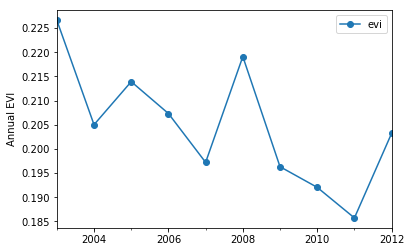

In [12]:
eviyr = evidf.groupby(pd.TimeGrouper('A')).aggregate(np.average)

# plot
eviyr.plot(marker='o')
plt.ylabel('Annual EVI')

The annual EVI values are lower in years 2009-2011 when the tree mortality due to Bark Beetles was the highest.

## 3. Download tree mortality from Bark Beetles with SDAT webservice

We will use "[Tree Mortality from Fires and Bark Beetles at 1-km Resolution, Western USA, 2003-2012](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1512)" dataset. This dataset provides annual estimates of tree mortality (as amount of aboveground carbon in the trees killed) due to fires and bark beetles from 2003 to 2012 on forestland in the continental western United States. The data is also available via SDAT at: https://webmap.ornl.gov/wcsdown/dataset.jsp?ds_id=1512. If you look up the URLs of each granules, you will notice that the bark beetle data from 2003-2012 have 'dg_id' of '1512_1', '1512_3', '1512_5',...,'1512_17', '1512_19'. These are the layer names we will need when accessing the SDAT service.

First, we will visualize the data using SDAT's Web Map Service (WMS). 

In [13]:
sdatwms = WebMapService('https://webmap.ornl.gov/ogcbroker/wms')

Now let's check what methods and format options are available for the WMS service:

In [14]:
[op.name for op in sdatwms.operations]

['GetCapabilities',
 'GetMap',
 'GetFeatureInfo',
 'DescribeLayer',
 'GetLegendGraphic',
 'GetStyles']

In [15]:
sdatwms.getOperationByName('GetMap').formatOptions

['image/png',
 'image/gif',
 'application/x-pdf',
 'image/jpeg',
 'image/png; mode=8bit',
 'image/svg+xml',
 'image/tiff',
 'application/vnd.google-earth.kml+xml',
 'application/vnd.google-earth.kmz']

We will use WMS 'getmap' to download the images in 'png' format for years 2003-2012.

2003


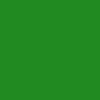

2004


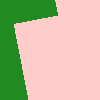

2005


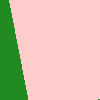

2006


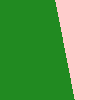

2007


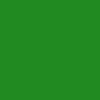

2008


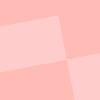

2009


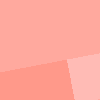

2010


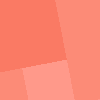

2011


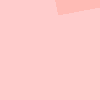

2012


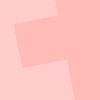

In [17]:
resx = 0.014 #degrees resolution
resy = 0.010

# The data range is 2003-2012
mortDates = [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012] 
# odd numbered array starting from 1 to 19
odd_i = range(1, 20, 2)
for i, j in enumerate(odd_i):
    layername = '1512_' + str(j)
    img = sdatwms.getmap(layers=[layername],
                     srs='EPSG:4326', # WGS 84
                     bbox=(lon-resx,lat-resy,lon+resx,lat+resy), 
                     size=(100, 100), 
                     format='image/png', 
                     transparent=True)
    print(mortDates[i])
    display(Image(img.read()))

In the above images, higher tree mortality is displayed in darker red and no mortality in green. We can see the mortality peaked around 2009-2010.

Now let's get the tree mortality rates using SDAT's WCS service.

In [20]:
sdatwcs = WebCoverageService('https://webmap.ornl.gov/ogcbroker/wcs')
mort = [] # array to store mortality values (Mg C km-2)

for i,j in enumerate(odd_i):
    layername = '1512_' + str(j)
    mortality = sdatwcs.getCoverage(identifier=layername,
                           bbox=(lon-resx,lat-resy,lon+resx,lat+resy),
                           crs='EPSG:4326',
                           format='XYZ_FLOAT32',
                           interpolation='NEAREST',
                           resx=resx,
                           resy=resy)
    
    # output from above is in bytes; lets convert to string
    mortOut = mortality.read().decode("utf-8")
    mortValue = []
    
    # loop through the output and store mortality values
    for k, lines in enumerate(mortOut.splitlines()):
        if k > 0: # skipping the header line
            mortValue.append(int(lines.split(',')[2]))
    
    # mean mortality (Mg C km-2)
    mort.append(np.mean(mortValue))


In [21]:
mortdf = pd.DataFrame(data=mort, index=mortDates, columns=['mortality'])

# print the tree mortality due to bark beetle
mortdf

,mortality
2003,0.00
2004,7.50
2005,2.00
2006,3.25
2007,0.00
2008,81.75
2009,869.25
2010,2180.75
2011,54.50
2012,192.75


## 4. Combining the results
The bark beetle infestation is often triggered by drought, with beetle activity becoming detectable within a year or two. As soon as the tree recovers from drought, the beetle [populations collapse and tree mortality diminishes](https://www.fs.usda.gov/detail/boise/news-events/?cid=STELPRD3841444). Now, can you put together the three datasets we just downloaded (vegetation index from MODIS, precipitation from Daymet and tree mortality) and try making sense of them?
